# Job - Pre-processing and Modelling Iteration 1

In [3]:
# libraries import

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

import re
import datetime
from datetime import date
from time import strptime

import RAKE as rake
import operator


######################################################################################

# Working on Job description Text Data
######################################################################################   

In [4]:
# reading my sorted job csv
job = pd.read_csv('wip/sorted_jobs_master.csv')

In [5]:
job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38941 entries, 0 to 38940
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           38941 non-null  object 
 1   education         38941 non-null  object 
 2   experience        38941 non-null  int64  
 3   industry          38941 non-null  object 
 4   jobdescription    38941 non-null  object 
 5   jobtitle          38941 non-null  object 
 6   payrate           38941 non-null  object 
 7   skills            38941 non-null  object 
 8   experience_range  38941 non-null  int64  
 9   industry_enum     38941 non-null  int64  
 10  Salary_range      38941 non-null  float64
 11  j_id              38941 non-null  int64  
 12  is_grad           38941 non-null  int64  
 13  is_postgrad       38941 non-null  int64  
 14  is_doc            38941 non-null  int64  
 15  location          38941 non-null  int64  
dtypes: float64(1), int64(8), object(7)
memor

###########################################################################################################################
# Understanding Job_description column (using NLP)
###########################################################################################################################


# 1. NLP - NLTK application to understand most used words

In [11]:
#Import all the dependencies
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
set(stopwords.words('english'))
# nltk.download('abc')
# from nltk.corpus import abc
# from nltk import RegexpTokenizer

import string
stopwords = set(stopwords.words("english"))
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shail\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# defining tokenizer 
def my_tokenizer(text):
    # 1. split at whitespace
    text = text.split(' ')
    
    #2. lowercase
    text = [word.lower() for word in text]
    
    #3. Remove puncutation
    #table to replace puncuation
    punc_table = str.maketrans('','',string.punctuation)
    
    #call translate()
    text = [word.translate(punc_table) for word in text]
    
    #4. remove stopwords
    text = [word for word in text if word not in stopwords]
    
    #5. lemmmatize
    lemmatizer = WordNetLemmatizer()
    
    text = [lemmatizer.lemmatize(word, pos='v') for word in text]
    text = [lemmatizer.lemmatize(word, pos='n') for word in text]
    text = [lemmatizer.lemmatize(word, pos='a') for word in text]
    
    #6. remove empty strings
    text = [word for word in text if word !='']
    
    return text 

In [13]:
#apply count vectorizor for tokenization
from sklearn.feature_extraction.text import CountVectorizer
# # # Now, time to count vectorize to get most used words in job description
X_train = job['jobdescription']
X_train.shape

# 1. Instantiate
bagofwords = CountVectorizer(min_df = 15, tokenizer = my_tokenizer)
# 2. Fit
bagofwords.fit(X_train)
# 3. Transform
X_train_p = bagofwords.transform(X_train)

# analysing JD words in dataframe
word_counts = np.array(np.sum(X_train_p, axis=0)).reshape((-1,))
words = np.array(bagofwords.get_feature_names())
words_df = pd.DataFrame({"word":words, 
                         "count":word_counts})
words_rank = words_df.sort_values(by="count", ascending=False)
words_rank.to_csv('jd_words_rank_.csv') # Storing for inspection 
words_rank.head()

,word,count
5415,job,140463
10756,,87571
7596,profile,84883
3031,description,75494
2388,company,72167


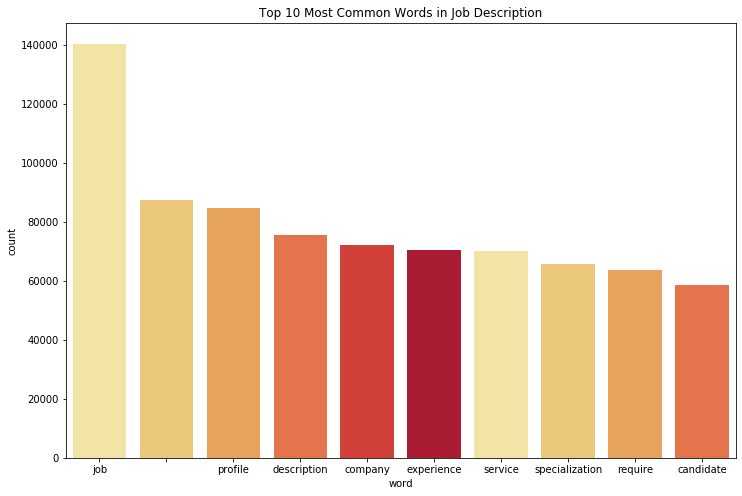

In [19]:
# Visualizing top 10 words
import seaborn as sns
plt.figure(figsize=(12,8))
rk_w = words_rank['count'].astype(str)
sns.barplot(words_rank['word'][:10], words_rank['count'][:10].astype(str), palette=sns.color_palette("YlOrRd"))
plt.title('Top 10 Most Common Words in Job Description')
plt.show()

# 2. NLP - TF-IDF application to get a list of all tokens 
-- This helped me to gather what words needed to be in stop-words list

In [4]:
df_job_descriptions = job[['j_id','jobtitle','company' ]]
df_job_descriptions['jd_combo'] = job['jobtitle'] +" " +  job['jobdescription'] +" " + job['skills'] + " " + job['industry']
df_job_descriptions.head()

C:\Users\shail\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,j_id,jobtitle,company,jd_combo
0,0,walkin data entry operator (night shift),MM Media Pvt Ltd,walkin data entry operator (night shift) Job D...
1,1,work based onhome based part time.,find live infotech,work based onhome based part time. Job Descrip...
2,2,pl/sql developer - sql,Softtech Career Infosystem Pvt. Ltd,pl/sql developer - sql Job Description Send ...
3,3,manager/ad/partner - indirect tax - ca,Onboard HRServices LLP,manager/ad/partner - indirect tax - ca Job Des...
4,4,manager/ad/partner - indirect tax - ca,Onboard HRServices LLP,manager/ad/partner - indirect tax - ca Job Des...


In [16]:
#apply tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('ã¯æ’ëœ')
#Transforms words to TFIDF
vectorizer = TfidfVectorizer(stop_words = stopwords)

index = 0
keys = {}

for jd in df_job_descriptions.itertuples() :
    key = jd[1]
    keys[key] = index
    index += 1

#Fit the vectorizer to the data
vectorizer.fit(df_job_descriptions['jd_combo'].fillna(''))

#Transform the data
tfidf_scores = vectorizer.transform(df_job_descriptions['jd_combo'].fillna(''))

print(tfidf_scores.shape)
print(df_job_descriptions.shape)

C:\Users\shail\anaconda\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ëœ'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(38941, 58510)
(38941, 4)


In [17]:
#get all words 
test = pd.DataFrame(tfidf_scores.toarray(), columns = vectorizer.get_feature_names())

In [18]:
#Show
test.head()

,00,000,0000,00000,0000gmt,0001pt,00029,00034,000402,00053,...,ïƒ,ïƒ¼,ïƒž,œ100,œmost,œrecognition,œto,šâ,šã,žâ
0,0.0,0.055441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.065396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As count vectorizer and Tf-Idf are only exploding my column numbers. It might not be wise to proceed with any of these. Moveover, I need to compare job description with Resume, that may not with fair comparison. So I will use these results so far for customizing stop word list. And will later use Doc2Vec to train my model.

# Creating my Stopword list 

### As seen there are so many unwanted tokens like numbers,ïƒ¼ etc , I need to add them in "stop words" list to train model 

In [19]:
#getting list of all tokens
word_list = test.columns.tolist()

In [20]:
##Getting a list of unwanted words as s_words and adding to stopwords
s_words =[]
for word in word_list:
    #print(word)
    if re.search("^\W|^\d",word):
        s_words.append(word)
        

In [21]:
s_words.append('')        
from nltk.corpus import stopwords
stopword_set = set(stopwords.words('english'))
stopword_set = list(stopword_set)
stopword_set.extend(s_words)

## Collecting all text data for DOC2VEC modelling

In [5]:
# using concatenated text columns
docs = df_job_descriptions['jd_combo']
docs_sample = docs.head(10)
docs_sample

0    walkin data entry operator (night shift) Job D...
1    work based onhome based part time. Job Descrip...
2    pl/sql developer - sql Job Description   Send ...
3    manager/ad/partner - indirect tax - ca Job Des...
4    manager/ad/partner - indirect tax - ca Job Des...
5    manager/ad/partner - indirect tax - ca Job Des...
6    manager/ad/partner - indirect tax - ca Job Des...
7    manager/ad/partner - indirect tax - ca Job Des...
8    manager/ad/partner - indirect tax - ca Job Des...
9    java technical lead (6-8 yrs) - Job Descriptio...
Name: jd_combo, dtype: object

In [12]:
#pre-processing with custom stop word list
def preprocess(text):
    stop_words = stopword_set
    #0. split words by whitespace
    text = text.split()
    
    
    # 1. lower case
    text = [word.lower() for word in text]
    
    # 2. remove punctuations
    punc_table = str.maketrans('','',string.punctuation)
    text = [word.translate(punc_table) for word in text]
    
    # 3. remove stop words
    text = [word for word in text if word not in stop_words]
    
    return text

In [33]:
# calling my pre-process to tokenize 
tokenized_doc = []
doc = df_job_descriptions['jd_combo']
#doc = docs_sample
for d in doc:
    tokenized_doc.append(preprocess(d))
#tokenized_doc

In [34]:
# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]

In [35]:
num_doc = len(tagged_data) #should be 38941
num_doc

38941

In [36]:
#settings to show epoch progress
from gensim.test.utils import get_tmpfile
from gensim.models.callbacks import CallbackAny2Vec

class EpochSaver(CallbackAny2Vec):

    def __init__(self, path_prefix):
        self.path_prefix = path_prefix
        self.epoch = 0

    def on_epoch_end(self, model):
        output_path = get_tmpfile('{}_epoch{}.model'.format(self.path_prefix, self.epoch))
        model.save(output_path)
        self.epoch += 1

In [37]:
#settings to show epoch progress
class EpochLogger(CallbackAny2Vec):
    
    def __init__(self):
        self.epoch = 0
        
    def on_epoch_begin(self, model):
        print("Epoch #{} start".format(self.epoch))

    def on_epoch_end(self, model):
        print("Epoch #{} end".format(self.epoch))
        self.epoch += 1

In [110]:
epoch_logger = EpochLogger()
## Train doc2vec model
model = Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, workers=4, epochs = 100, callbacks=[epoch_logger])


2020-07-18 02:41:53,918 : INFO : collecting all words and their counts
2020-07-18 02:41:53,919 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-07-18 02:41:54,314 : INFO : PROGRESS: at example #10000, processed 1857280 words (4727802/s), 36041 word types, 10000 tags
2020-07-18 02:41:54,719 : INFO : PROGRESS: at example #20000, processed 3885093 words (5019544/s), 58195 word types, 20000 tags
2020-07-18 02:41:55,166 : INFO : PROGRESS: at example #30000, processed 6066314 words (4883975/s), 74364 word types, 30000 tags
2020-07-18 02:41:55,515 : INFO : collected 85418 word types and 38941 unique tags from a corpus of 38941 examples and 7816975 words
2020-07-18 02:41:55,516 : INFO : Loading a fresh vocabulary
2020-07-18 02:41:55,688 : INFO : effective_min_count=1 retains 85418 unique words (100% of original 85418, drops 0)
2020-07-18 02:41:55,689 : INFO : effective_min_count=1 leaves 7816975 word corpus (100% of original 7816975, drops 0)
2020-07-18 02:4

Epoch #0 start


2020-07-18 02:42:23,259 : INFO : EPOCH 1 - PROGRESS: at 13.20% examples, 856236 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:24,270 : INFO : EPOCH 1 - PROGRESS: at 26.57% examples, 844401 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:25,275 : INFO : EPOCH 1 - PROGRESS: at 39.92% examples, 863001 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:26,280 : INFO : EPOCH 1 - PROGRESS: at 52.44% examples, 881803 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:27,283 : INFO : EPOCH 1 - PROGRESS: at 63.41% examples, 877413 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:28,285 : INFO : EPOCH 1 - PROGRESS: at 74.75% examples, 868540 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:29,297 : INFO : EPOCH 1 - PROGRESS: at 86.97% examples, 862210 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:30,301 : INFO : EPOCH 1 - PROGRESS: at 99.76% examples, 860194 words/s, in_qsize 3, out_qsize 1
2020-07-18 02:42:30,304 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-

Epoch #0 end
Epoch #1 start


2020-07-18 02:42:31,332 : INFO : EPOCH 2 - PROGRESS: at 13.59% examples, 883531 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:32,336 : INFO : EPOCH 2 - PROGRESS: at 26.02% examples, 831331 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:33,336 : INFO : EPOCH 2 - PROGRESS: at 38.21% examples, 829437 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:34,341 : INFO : EPOCH 2 - PROGRESS: at 50.53% examples, 838213 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:35,343 : INFO : EPOCH 2 - PROGRESS: at 60.70% examples, 824907 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:36,347 : INFO : EPOCH 2 - PROGRESS: at 71.74% examples, 837092 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:37,354 : INFO : EPOCH 2 - PROGRESS: at 84.28% examples, 838531 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:38,357 : INFO : EPOCH 2 - PROGRESS: at 95.95% examples, 829142 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:38,724 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-

Epoch #1 end
Epoch #2 start


2020-07-18 02:42:39,758 : INFO : EPOCH 3 - PROGRESS: at 12.03% examples, 766287 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:40,773 : INFO : EPOCH 3 - PROGRESS: at 25.33% examples, 803134 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:41,783 : INFO : EPOCH 3 - PROGRESS: at 37.94% examples, 816134 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:42,791 : INFO : EPOCH 3 - PROGRESS: at 48.57% examples, 794845 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:43,811 : INFO : EPOCH 3 - PROGRESS: at 57.92% examples, 778511 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:44,826 : INFO : EPOCH 3 - PROGRESS: at 67.90% examples, 785917 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:45,826 : INFO : EPOCH 3 - PROGRESS: at 80.01% examples, 791826 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:46,826 : INFO : EPOCH 3 - PROGRESS: at 93.12% examples, 801237 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:47,403 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-

Epoch #2 end
Epoch #3 start


2020-07-18 02:42:48,454 : INFO : EPOCH 4 - PROGRESS: at 11.63% examples, 730900 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:49,459 : INFO : EPOCH 4 - PROGRESS: at 24.03% examples, 763405 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:50,470 : INFO : EPOCH 4 - PROGRESS: at 34.59% examples, 743630 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:51,470 : INFO : EPOCH 4 - PROGRESS: at 44.22% examples, 717846 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:52,473 : INFO : EPOCH 4 - PROGRESS: at 54.83% examples, 742970 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:53,486 : INFO : EPOCH 4 - PROGRESS: at 66.75% examples, 775927 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:54,499 : INFO : EPOCH 4 - PROGRESS: at 77.13% examples, 764617 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:42:55,501 : INFO : EPOCH 4 - PROGRESS: at 89.63% examples, 775098 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:56,279 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-

Epoch #3 end
Epoch #4 start


2020-07-18 02:42:57,305 : INFO : EPOCH 5 - PROGRESS: at 12.72% examples, 820378 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:58,312 : INFO : EPOCH 5 - PROGRESS: at 26.42% examples, 841038 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:42:59,312 : INFO : EPOCH 5 - PROGRESS: at 38.34% examples, 830090 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:00,316 : INFO : EPOCH 5 - PROGRESS: at 51.03% examples, 847956 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:01,316 : INFO : EPOCH 5 - PROGRESS: at 62.45% examples, 857764 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:02,324 : INFO : EPOCH 5 - PROGRESS: at 73.59% examples, 856263 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:03,324 : INFO : EPOCH 5 - PROGRESS: at 86.48% examples, 859340 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:04,331 : INFO : EPOCH 5 - PROGRESS: at 99.10% examples, 854969 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:04,401 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-

Epoch #4 end
Epoch #5 start


2020-07-18 02:43:05,476 : INFO : EPOCH 6 - PROGRESS: at 12.72% examples, 801877 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:06,486 : INFO : EPOCH 6 - PROGRESS: at 25.77% examples, 809152 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:07,492 : INFO : EPOCH 6 - PROGRESS: at 37.94% examples, 812652 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:08,496 : INFO : EPOCH 6 - PROGRESS: at 50.83% examples, 836662 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:09,499 : INFO : EPOCH 6 - PROGRESS: at 59.52% examples, 802559 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:10,512 : INFO : EPOCH 6 - PROGRESS: at 69.03% examples, 801875 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:11,513 : INFO : EPOCH 6 - PROGRESS: at 81.09% examples, 802766 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:12,516 : INFO : EPOCH 6 - PROGRESS: at 94.86% examples, 816081 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:12,879 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-

Epoch #5 end
Epoch #6 start


2020-07-18 02:43:13,890 : INFO : EPOCH 7 - PROGRESS: at 12.72% examples, 818140 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:14,910 : INFO : EPOCH 7 - PROGRESS: at 25.50% examples, 808823 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:15,917 : INFO : EPOCH 7 - PROGRESS: at 35.81% examples, 772185 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:16,917 : INFO : EPOCH 7 - PROGRESS: at 48.68% examples, 800194 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:17,926 : INFO : EPOCH 7 - PROGRESS: at 61.17% examples, 828044 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:18,944 : INFO : EPOCH 7 - PROGRESS: at 73.60% examples, 852353 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:19,946 : INFO : EPOCH 7 - PROGRESS: at 87.20% examples, 863203 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:20,953 : INFO : EPOCH 7 - PROGRESS: at 99.42% examples, 855225 words/s, in_qsize 6, out_qsize 0
2020-07-18 02:43:20,964 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-

Epoch #6 end
Epoch #7 start


2020-07-18 02:43:22,001 : INFO : EPOCH 8 - PROGRESS: at 13.10% examples, 844751 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:23,008 : INFO : EPOCH 8 - PROGRESS: at 26.82% examples, 853246 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:24,012 : INFO : EPOCH 8 - PROGRESS: at 40.31% examples, 871881 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:25,013 : INFO : EPOCH 8 - PROGRESS: at 52.78% examples, 889349 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:26,024 : INFO : EPOCH 8 - PROGRESS: at 63.95% examples, 885644 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:27,043 : INFO : EPOCH 8 - PROGRESS: at 76.51% examples, 885733 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:28,054 : INFO : EPOCH 8 - PROGRESS: at 89.64% examples, 885534 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:28,840 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:43:28,855 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:43:28,858 : I

Epoch #7 end
Epoch #8 start


2020-07-18 02:43:29,891 : INFO : EPOCH 9 - PROGRESS: at 13.23% examples, 838772 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:30,899 : INFO : EPOCH 9 - PROGRESS: at 25.64% examples, 807362 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:31,911 : INFO : EPOCH 9 - PROGRESS: at 38.98% examples, 835920 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:32,920 : INFO : EPOCH 9 - PROGRESS: at 51.92% examples, 862169 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:33,918 : INFO : EPOCH 9 - PROGRESS: at 64.30% examples, 888206 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:34,928 : INFO : EPOCH 9 - PROGRESS: at 77.52% examples, 895393 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:35,932 : INFO : EPOCH 9 - PROGRESS: at 90.58% examples, 893455 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:36,649 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:43:36,652 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:43:36,664 : I

Epoch #8 end
Epoch #9 start


2020-07-18 02:43:37,681 : INFO : EPOCH 10 - PROGRESS: at 13.24% examples, 848489 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:38,693 : INFO : EPOCH 10 - PROGRESS: at 27.08% examples, 857106 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:39,713 : INFO : EPOCH 10 - PROGRESS: at 40.44% examples, 867673 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:40,722 : INFO : EPOCH 10 - PROGRESS: at 53.18% examples, 890423 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:41,730 : INFO : EPOCH 10 - PROGRESS: at 64.43% examples, 890809 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:42,735 : INFO : EPOCH 10 - PROGRESS: at 77.26% examples, 891797 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:43,739 : INFO : EPOCH 10 - PROGRESS: at 89.93% examples, 886595 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:44,507 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:43:44,514 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:43:44,

Epoch #9 end
Epoch #10 start


2020-07-18 02:43:45,532 : INFO : EPOCH 11 - PROGRESS: at 12.35% examples, 796563 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:46,538 : INFO : EPOCH 11 - PROGRESS: at 24.86% examples, 792191 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:47,556 : INFO : EPOCH 11 - PROGRESS: at 37.81% examples, 815067 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:48,565 : INFO : EPOCH 11 - PROGRESS: at 50.93% examples, 841733 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:49,571 : INFO : EPOCH 11 - PROGRESS: at 62.51% examples, 855339 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:50,583 : INFO : EPOCH 11 - PROGRESS: at 73.31% examples, 849342 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:51,588 : INFO : EPOCH 11 - PROGRESS: at 85.96% examples, 850477 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:43:52,590 : INFO : EPOCH 11 - PROGRESS: at 97.36% examples, 836719 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:52,783 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #10 end
Epoch #11 start


2020-07-18 02:43:53,821 : INFO : EPOCH 12 - PROGRESS: at 13.23% examples, 846084 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:54,833 : INFO : EPOCH 12 - PROGRESS: at 26.96% examples, 851555 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:55,845 : INFO : EPOCH 12 - PROGRESS: at 37.81% examples, 811072 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:56,858 : INFO : EPOCH 12 - PROGRESS: at 50.65% examples, 831592 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:57,864 : INFO : EPOCH 12 - PROGRESS: at 61.17% examples, 823915 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:58,866 : INFO : EPOCH 12 - PROGRESS: at 73.17% examples, 846688 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:43:59,874 : INFO : EPOCH 12 - PROGRESS: at 86.22% examples, 851428 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:00,888 : INFO : EPOCH 12 - PROGRESS: at 99.42% examples, 852868 words/s, in_qsize 6, out_qsize 0
2020-07-18 02:44:00,916 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #11 end
Epoch #12 start


2020-07-18 02:44:01,951 : INFO : EPOCH 13 - PROGRESS: at 12.68% examples, 811590 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:02,953 : INFO : EPOCH 13 - PROGRESS: at 25.19% examples, 800489 words/s, in_qsize 6, out_qsize 1
2020-07-18 02:44:03,954 : INFO : EPOCH 13 - PROGRESS: at 38.58% examples, 834747 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:04,965 : INFO : EPOCH 13 - PROGRESS: at 51.56% examples, 858528 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:05,965 : INFO : EPOCH 13 - PROGRESS: at 63.72% examples, 882217 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:06,984 : INFO : EPOCH 13 - PROGRESS: at 76.62% examples, 887281 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:07,990 : INFO : EPOCH 13 - PROGRESS: at 88.43% examples, 874057 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:08,848 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:44:08,851 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:44:08,

Epoch #12 end
Epoch #13 start


2020-07-18 02:44:09,867 : INFO : EPOCH 14 - PROGRESS: at 13.47% examples, 875199 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:10,881 : INFO : EPOCH 14 - PROGRESS: at 27.34% examples, 869468 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:11,882 : INFO : EPOCH 14 - PROGRESS: at 40.56% examples, 878402 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:12,906 : INFO : EPOCH 14 - PROGRESS: at 52.54% examples, 880317 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:13,909 : INFO : EPOCH 14 - PROGRESS: at 64.90% examples, 903017 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:14,914 : INFO : EPOCH 14 - PROGRESS: at 78.15% examples, 904660 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:15,919 : INFO : EPOCH 14 - PROGRESS: at 91.00% examples, 898662 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:16,576 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:44:16,588 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:44:16,

Epoch #13 end
Epoch #14 start


2020-07-18 02:44:17,612 : INFO : EPOCH 15 - PROGRESS: at 13.47% examples, 868926 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:18,624 : INFO : EPOCH 15 - PROGRESS: at 26.16% examples, 829234 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:19,628 : INFO : EPOCH 15 - PROGRESS: at 39.27% examples, 847047 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:20,632 : INFO : EPOCH 15 - PROGRESS: at 51.56% examples, 858432 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:21,644 : INFO : EPOCH 15 - PROGRESS: at 63.49% examples, 876561 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:22,649 : INFO : EPOCH 15 - PROGRESS: at 76.63% examples, 887440 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:23,661 : INFO : EPOCH 15 - PROGRESS: at 88.78% examples, 877291 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:24,478 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:44:24,483 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:44:24,

Epoch #14 end
Epoch #15 start


2020-07-18 02:44:25,512 : INFO : EPOCH 16 - PROGRESS: at 12.97% examples, 830920 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:26,517 : INFO : EPOCH 16 - PROGRESS: at 26.02% examples, 826084 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:27,524 : INFO : EPOCH 16 - PROGRESS: at 39.27% examples, 847034 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:28,527 : INFO : EPOCH 16 - PROGRESS: at 51.35% examples, 854265 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:29,533 : INFO : EPOCH 16 - PROGRESS: at 62.82% examples, 863705 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:30,544 : INFO : EPOCH 16 - PROGRESS: at 74.62% examples, 864760 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:31,552 : INFO : EPOCH 16 - PROGRESS: at 86.85% examples, 859516 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:32,558 : INFO : EPOCH 16 - PROGRESS: at 99.42% examples, 855336 words/s, in_qsize 6, out_qsize 0
2020-07-18 02:44:32,582 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #15 end
Epoch #16 start


2020-07-18 02:44:33,618 : INFO : EPOCH 17 - PROGRESS: at 13.70% examples, 891489 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:34,623 : INFO : EPOCH 17 - PROGRESS: at 26.42% examples, 843331 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:35,642 : INFO : EPOCH 17 - PROGRESS: at 39.77% examples, 858000 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:36,659 : INFO : EPOCH 17 - PROGRESS: at 52.17% examples, 870885 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:37,679 : INFO : EPOCH 17 - PROGRESS: at 63.90% examples, 879956 words/s, in_qsize 7, out_qsize 1
2020-07-18 02:44:38,682 : INFO : EPOCH 17 - PROGRESS: at 76.37% examples, 881666 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:39,684 : INFO : EPOCH 17 - PROGRESS: at 88.15% examples, 869927 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:40,540 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:44:40,546 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:44:40,

Epoch #16 end
Epoch #17 start


2020-07-18 02:44:41,583 : INFO : EPOCH 18 - PROGRESS: at 13.24% examples, 841948 words/s, in_qsize 8, out_qsize 1
2020-07-18 02:44:42,586 : INFO : EPOCH 18 - PROGRESS: at 27.08% examples, 857927 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:43,587 : INFO : EPOCH 18 - PROGRESS: at 39.77% examples, 858988 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:44,604 : INFO : EPOCH 18 - PROGRESS: at 51.37% examples, 851543 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:45,615 : INFO : EPOCH 18 - PROGRESS: at 62.63% examples, 855184 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:46,627 : INFO : EPOCH 18 - PROGRESS: at 75.39% examples, 870748 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:47,628 : INFO : EPOCH 18 - PROGRESS: at 88.43% examples, 872808 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:48,470 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:44:48,485 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:44:48,

Epoch #17 end
Epoch #18 start


2020-07-18 02:44:49,510 : INFO : EPOCH 19 - PROGRESS: at 12.72% examples, 817583 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:50,517 : INFO : EPOCH 19 - PROGRESS: at 25.33% examples, 805049 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:51,520 : INFO : EPOCH 19 - PROGRESS: at 38.70% examples, 837327 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:52,538 : INFO : EPOCH 19 - PROGRESS: at 51.73% examples, 861308 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:53,545 : INFO : EPOCH 19 - PROGRESS: at 63.72% examples, 879821 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:54,546 : INFO : EPOCH 19 - PROGRESS: at 76.63% examples, 887763 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:55,551 : INFO : EPOCH 19 - PROGRESS: at 88.55% examples, 875794 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:56,373 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:44:56,386 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:44:56,

Epoch #18 end
Epoch #19 start


2020-07-18 02:44:57,434 : INFO : EPOCH 20 - PROGRESS: at 13.69% examples, 865687 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:44:58,448 : INFO : EPOCH 20 - PROGRESS: at 27.72% examples, 869091 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:44:59,466 : INFO : EPOCH 20 - PROGRESS: at 41.39% examples, 881624 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:00,468 : INFO : EPOCH 20 - PROGRESS: at 52.25% examples, 868150 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:01,470 : INFO : EPOCH 20 - PROGRESS: at 64.43% examples, 889504 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:02,474 : INFO : EPOCH 20 - PROGRESS: at 77.13% examples, 889529 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:03,490 : INFO : EPOCH 20 - PROGRESS: at 90.43% examples, 889366 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:04,187 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:45:04,198 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:45:04,

Epoch #19 end
Epoch #20 start


2020-07-18 02:45:05,222 : INFO : EPOCH 21 - PROGRESS: at 12.35% examples, 788670 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:06,243 : INFO : EPOCH 21 - PROGRESS: at 24.71% examples, 781593 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:07,252 : INFO : EPOCH 21 - PROGRESS: at 38.34% examples, 822030 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:08,262 : INFO : EPOCH 21 - PROGRESS: at 50.83% examples, 835837 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:09,268 : INFO : EPOCH 21 - PROGRESS: at 62.69% examples, 855692 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:10,269 : INFO : EPOCH 21 - PROGRESS: at 74.40% examples, 859915 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:11,279 : INFO : EPOCH 21 - PROGRESS: at 85.70% examples, 846572 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:12,284 : INFO : EPOCH 21 - PROGRESS: at 98.32% examples, 842790 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:12,400 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #20 end
Epoch #21 start


2020-07-18 02:45:13,432 : INFO : EPOCH 22 - PROGRESS: at 11.88% examples, 759227 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:14,443 : INFO : EPOCH 22 - PROGRESS: at 23.58% examples, 753524 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:15,445 : INFO : EPOCH 22 - PROGRESS: at 35.81% examples, 773596 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:16,447 : INFO : EPOCH 22 - PROGRESS: at 47.56% examples, 781687 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:17,459 : INFO : EPOCH 22 - PROGRESS: at 56.62% examples, 765231 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:18,466 : INFO : EPOCH 22 - PROGRESS: at 65.90% examples, 767334 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:19,471 : INFO : EPOCH 22 - PROGRESS: at 77.00% examples, 765640 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:20,472 : INFO : EPOCH 22 - PROGRESS: at 88.78% examples, 769621 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:21,488 : INFO : EPOCH 22 - PROGRESS: at 99.42% examples, 760651 words/s

Epoch #21 end
Epoch #22 start


2020-07-18 02:45:22,544 : INFO : EPOCH 23 - PROGRESS: at 11.88% examples, 758911 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:23,565 : INFO : EPOCH 23 - PROGRESS: at 24.03% examples, 762743 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:24,571 : INFO : EPOCH 23 - PROGRESS: at 35.66% examples, 767055 words/s, in_qsize 8, out_qsize 1
2020-07-18 02:45:25,573 : INFO : EPOCH 23 - PROGRESS: at 48.20% examples, 789644 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:26,573 : INFO : EPOCH 23 - PROGRESS: at 58.79% examples, 794584 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:27,585 : INFO : EPOCH 23 - PROGRESS: at 68.80% examples, 801213 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:28,597 : INFO : EPOCH 23 - PROGRESS: at 80.15% examples, 794872 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:29,615 : INFO : EPOCH 23 - PROGRESS: at 93.80% examples, 806496 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:30,057 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #22 end
Epoch #23 start


2020-07-18 02:45:31,104 : INFO : EPOCH 24 - PROGRESS: at 12.27% examples, 777573 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:32,112 : INFO : EPOCH 24 - PROGRESS: at 23.87% examples, 759180 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:33,119 : INFO : EPOCH 24 - PROGRESS: at 36.79% examples, 790139 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:34,129 : INFO : EPOCH 24 - PROGRESS: at 49.23% examples, 805666 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:35,133 : INFO : EPOCH 24 - PROGRESS: at 60.83% examples, 820987 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:36,146 : INFO : EPOCH 24 - PROGRESS: at 72.79% examples, 842904 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:37,151 : INFO : EPOCH 24 - PROGRESS: at 84.68% examples, 837482 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:38,154 : INFO : EPOCH 24 - PROGRESS: at 97.65% examples, 838121 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:38,331 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #23 end
Epoch #24 start


2020-07-18 02:45:39,376 : INFO : EPOCH 25 - PROGRESS: at 12.72% examples, 810852 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:40,378 : INFO : EPOCH 25 - PROGRESS: at 25.77% examples, 817038 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:41,383 : INFO : EPOCH 25 - PROGRESS: at 38.08% examples, 821180 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:42,398 : INFO : EPOCH 25 - PROGRESS: at 49.59% examples, 812249 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:43,403 : INFO : EPOCH 25 - PROGRESS: at 61.60% examples, 835272 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:44,402 : INFO : EPOCH 25 - PROGRESS: at 73.45% examples, 851879 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:45,430 : INFO : EPOCH 25 - PROGRESS: at 86.47% examples, 853536 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:46,439 : INFO : EPOCH 25 - PROGRESS: at 99.42% examples, 853005 words/s, in_qsize 6, out_qsize 0
2020-07-18 02:45:46,465 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #24 end
Epoch #25 start


2020-07-18 02:45:47,517 : INFO : EPOCH 26 - PROGRESS: at 12.72% examples, 800747 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:48,517 : INFO : EPOCH 26 - PROGRESS: at 25.50% examples, 803976 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:49,520 : INFO : EPOCH 26 - PROGRESS: at 38.07% examples, 818825 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:50,520 : INFO : EPOCH 26 - PROGRESS: at 49.71% examples, 815915 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:51,533 : INFO : EPOCH 26 - PROGRESS: at 61.40% examples, 831532 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:52,534 : INFO : EPOCH 26 - PROGRESS: at 72.79% examples, 844600 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:53,536 : INFO : EPOCH 26 - PROGRESS: at 84.15% examples, 834284 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:54,544 : INFO : EPOCH 26 - PROGRESS: at 94.97% examples, 818572 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:55,055 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #25 end
Epoch #26 start


2020-07-18 02:45:56,093 : INFO : EPOCH 27 - PROGRESS: at 11.88% examples, 761134 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:45:57,097 : INFO : EPOCH 27 - PROGRESS: at 25.77% examples, 821990 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:58,117 : INFO : EPOCH 27 - PROGRESS: at 38.45% examples, 829463 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:45:59,122 : INFO : EPOCH 27 - PROGRESS: at 50.04% examples, 822646 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:00,123 : INFO : EPOCH 27 - PROGRESS: at 60.97% examples, 824948 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:01,129 : INFO : EPOCH 27 - PROGRESS: at 72.01% examples, 837065 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:02,133 : INFO : EPOCH 27 - PROGRESS: at 84.91% examples, 842489 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:03,138 : INFO : EPOCH 27 - PROGRESS: at 97.61% examples, 840215 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:03,332 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #26 end
Epoch #27 start


2020-07-18 02:46:04,397 : INFO : EPOCH 28 - PROGRESS: at 11.05% examples, 698060 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:05,400 : INFO : EPOCH 28 - PROGRESS: at 23.45% examples, 746945 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:06,401 : INFO : EPOCH 28 - PROGRESS: at 36.66% examples, 789431 words/s, in_qsize 6, out_qsize 1
2020-07-18 02:46:07,408 : INFO : EPOCH 28 - PROGRESS: at 47.85% examples, 783868 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:08,409 : INFO : EPOCH 28 - PROGRESS: at 59.90% examples, 811104 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:09,410 : INFO : EPOCH 28 - PROGRESS: at 70.22% examples, 819071 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:10,413 : INFO : EPOCH 28 - PROGRESS: at 83.22% examples, 827084 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:11,426 : INFO : EPOCH 28 - PROGRESS: at 96.63% examples, 832308 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:11,646 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #27 end
Epoch #28 start


2020-07-18 02:46:12,676 : INFO : EPOCH 29 - PROGRESS: at 12.03% examples, 770372 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:13,682 : INFO : EPOCH 29 - PROGRESS: at 24.28% examples, 778344 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:14,690 : INFO : EPOCH 29 - PROGRESS: at 36.09% examples, 779873 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:15,704 : INFO : EPOCH 29 - PROGRESS: at 48.23% examples, 790442 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:16,706 : INFO : EPOCH 29 - PROGRESS: at 60.70% examples, 821334 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:17,726 : INFO : EPOCH 29 - PROGRESS: at 72.51% examples, 840690 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:18,727 : INFO : EPOCH 29 - PROGRESS: at 85.83% examples, 849605 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:19,733 : INFO : EPOCH 29 - PROGRESS: at 97.91% examples, 840829 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:19,877 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #28 end
Epoch #29 start


2020-07-18 02:46:20,905 : INFO : EPOCH 30 - PROGRESS: at 13.24% examples, 849951 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:21,935 : INFO : EPOCH 30 - PROGRESS: at 26.02% examples, 816759 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:22,940 : INFO : EPOCH 30 - PROGRESS: at 39.24% examples, 841433 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:23,952 : INFO : EPOCH 30 - PROGRESS: at 51.73% examples, 856902 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:24,956 : INFO : EPOCH 30 - PROGRESS: at 62.45% examples, 849998 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:25,962 : INFO : EPOCH 30 - PROGRESS: at 74.02% examples, 854479 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:26,963 : INFO : EPOCH 30 - PROGRESS: at 87.07% examples, 860343 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:27,920 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:46:27,924 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:46:27,

Epoch #29 end
Epoch #30 start


2020-07-18 02:46:28,941 : INFO : EPOCH 31 - PROGRESS: at 12.97% examples, 838883 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:29,942 : INFO : EPOCH 31 - PROGRESS: at 25.33% examples, 809534 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:30,965 : INFO : EPOCH 31 - PROGRESS: at 38.84% examples, 837574 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:31,967 : INFO : EPOCH 31 - PROGRESS: at 51.27% examples, 851785 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:32,982 : INFO : EPOCH 31 - PROGRESS: at 61.31% examples, 829984 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:33,992 : INFO : EPOCH 31 - PROGRESS: at 72.02% examples, 834598 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:35,003 : INFO : EPOCH 31 - PROGRESS: at 82.39% examples, 815143 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:36,006 : INFO : EPOCH 31 - PROGRESS: at 94.75% examples, 814973 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:36,422 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #30 end
Epoch #31 start


2020-07-18 02:46:37,453 : INFO : EPOCH 32 - PROGRESS: at 11.88% examples, 761030 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:38,452 : INFO : EPOCH 32 - PROGRESS: at 24.28% examples, 780434 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:39,460 : INFO : EPOCH 32 - PROGRESS: at 36.79% examples, 796053 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:40,461 : INFO : EPOCH 32 - PROGRESS: at 47.33% examples, 778957 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:41,477 : INFO : EPOCH 32 - PROGRESS: at 58.16% examples, 787374 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:42,485 : INFO : EPOCH 32 - PROGRESS: at 69.28% examples, 808868 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:43,489 : INFO : EPOCH 32 - PROGRESS: at 82.28% examples, 817044 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:44,491 : INFO : EPOCH 32 - PROGRESS: at 95.13% examples, 821149 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:44,982 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #31 end
Epoch #32 start


2020-07-18 02:46:46,025 : INFO : EPOCH 33 - PROGRESS: at 11.05% examples, 706455 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:47,031 : INFO : EPOCH 33 - PROGRESS: at 24.86% examples, 793730 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:48,034 : INFO : EPOCH 33 - PROGRESS: at 38.34% examples, 829788 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:49,056 : INFO : EPOCH 33 - PROGRESS: at 51.35% examples, 852428 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:50,059 : INFO : EPOCH 33 - PROGRESS: at 63.49% examples, 877060 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:51,065 : INFO : EPOCH 33 - PROGRESS: at 75.12% examples, 870347 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:52,069 : INFO : EPOCH 33 - PROGRESS: at 88.41% examples, 874799 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:52,928 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:46:52,946 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:46:52,

Epoch #32 end
Epoch #33 start


2020-07-18 02:46:53,961 : INFO : EPOCH 34 - PROGRESS: at 12.97% examples, 838793 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:54,983 : INFO : EPOCH 34 - PROGRESS: at 26.02% examples, 823048 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:55,988 : INFO : EPOCH 34 - PROGRESS: at 37.80% examples, 813706 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:56,994 : INFO : EPOCH 34 - PROGRESS: at 47.85% examples, 782757 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:46:58,002 : INFO : EPOCH 34 - PROGRESS: at 60.85% examples, 821297 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:58,997 : INFO : EPOCH 34 - PROGRESS: at 74.40% examples, 861696 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:46:59,996 : INFO : EPOCH 34 - PROGRESS: at 86.72% examples, 858990 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:00,991 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:47:01,006 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:47:01,

Epoch #33 end
Epoch #34 start


2020-07-18 02:47:02,028 : INFO : EPOCH 35 - PROGRESS: at 11.49% examples, 731621 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:03,041 : INFO : EPOCH 35 - PROGRESS: at 24.57% examples, 782470 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:04,035 : INFO : EPOCH 35 - PROGRESS: at 37.80% examples, 814882 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:05,052 : INFO : EPOCH 35 - PROGRESS: at 50.93% examples, 842496 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:06,054 : INFO : EPOCH 35 - PROGRESS: at 63.72% examples, 881602 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:07,057 : INFO : EPOCH 35 - PROGRESS: at 75.22% examples, 873376 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:08,061 : INFO : EPOCH 35 - PROGRESS: at 86.72% examples, 860084 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:09,022 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:47:09,043 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:47:09,

Epoch #34 end
Epoch #35 start


2020-07-18 02:47:10,065 : INFO : EPOCH 36 - PROGRESS: at 13.10% examples, 847253 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:11,066 : INFO : EPOCH 36 - PROGRESS: at 27.61% examples, 883261 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:12,061 : INFO : EPOCH 36 - PROGRESS: at 40.82% examples, 887253 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:13,072 : INFO : EPOCH 36 - PROGRESS: at 53.99% examples, 920108 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:14,063 : INFO : EPOCH 36 - PROGRESS: at 64.53% examples, 900978 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:15,084 : INFO : EPOCH 36 - PROGRESS: at 75.49% examples, 877980 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:16,107 : INFO : EPOCH 36 - PROGRESS: at 87.36% examples, 865370 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:17,113 : INFO : EPOCH 36 - PROGRESS: at 99.52% examples, 857254 words/s, in_qsize 5, out_qsize 0
2020-07-18 02:47:17,132 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #35 end
Epoch #36 start


2020-07-18 02:47:18,196 : INFO : EPOCH 37 - PROGRESS: at 14.16% examples, 912618 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:19,208 : INFO : EPOCH 37 - PROGRESS: at 28.74% examples, 910762 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:20,211 : INFO : EPOCH 37 - PROGRESS: at 40.96% examples, 882424 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:21,216 : INFO : EPOCH 37 - PROGRESS: at 54.23% examples, 918225 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:22,226 : INFO : EPOCH 37 - PROGRESS: at 64.86% examples, 902076 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:23,227 : INFO : EPOCH 37 - PROGRESS: at 76.51% examples, 885670 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:24,245 : INFO : EPOCH 37 - PROGRESS: at 88.66% examples, 874793 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:25,091 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:47:25,098 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:47:25,

Epoch #36 end
Epoch #37 start


2020-07-18 02:47:26,114 : INFO : EPOCH 38 - PROGRESS: at 11.75% examples, 753368 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:27,109 : INFO : EPOCH 38 - PROGRESS: at 24.44% examples, 783257 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:28,127 : INFO : EPOCH 38 - PROGRESS: at 36.77% examples, 795025 words/s, in_qsize 7, out_qsize 1
2020-07-18 02:47:29,131 : INFO : EPOCH 38 - PROGRESS: at 49.59% examples, 816866 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:30,138 : INFO : EPOCH 38 - PROGRESS: at 61.60% examples, 838453 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:31,142 : INFO : EPOCH 38 - PROGRESS: at 72.01% examples, 838114 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:32,145 : INFO : EPOCH 38 - PROGRESS: at 85.96% examples, 852290 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:33,148 : INFO : EPOCH 38 - PROGRESS: at 98.69% examples, 849219 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:33,231 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #37 end
Epoch #38 start


2020-07-18 02:47:34,268 : INFO : EPOCH 39 - PROGRESS: at 12.97% examples, 836055 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:35,273 : INFO : EPOCH 39 - PROGRESS: at 25.46% examples, 811696 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:36,280 : INFO : EPOCH 39 - PROGRESS: at 36.37% examples, 784904 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:37,292 : INFO : EPOCH 39 - PROGRESS: at 49.11% examples, 805434 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:38,326 : INFO : EPOCH 39 - PROGRESS: at 59.65% examples, 802145 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:39,341 : INFO : EPOCH 39 - PROGRESS: at 71.33% examples, 824012 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:40,353 : INFO : EPOCH 39 - PROGRESS: at 84.15% examples, 829022 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:41,340 : INFO : EPOCH 39 - PROGRESS: at 95.81% examples, 821224 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:41,684 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #38 end
Epoch #39 start


2020-07-18 02:47:42,735 : INFO : EPOCH 40 - PROGRESS: at 11.49% examples, 730694 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:43,724 : INFO : EPOCH 40 - PROGRESS: at 21.35% examples, 686449 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:44,746 : INFO : EPOCH 40 - PROGRESS: at 34.59% examples, 747552 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:45,753 : INFO : EPOCH 40 - PROGRESS: at 46.84% examples, 767370 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:46,754 : INFO : EPOCH 40 - PROGRESS: at 59.52% examples, 806606 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:47,745 : INFO : EPOCH 40 - PROGRESS: at 71.89% examples, 836587 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:48,768 : INFO : EPOCH 40 - PROGRESS: at 84.82% examples, 841374 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:49,778 : INFO : EPOCH 40 - PROGRESS: at 97.61% examples, 839720 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:49,946 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #39 end
Epoch #40 start


2020-07-18 02:47:50,990 : INFO : EPOCH 41 - PROGRESS: at 12.68% examples, 812804 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:51,996 : INFO : EPOCH 41 - PROGRESS: at 27.08% examples, 858703 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:53,017 : INFO : EPOCH 41 - PROGRESS: at 41.51% examples, 891660 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:54,016 : INFO : EPOCH 41 - PROGRESS: at 53.92% examples, 910932 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:55,019 : INFO : EPOCH 41 - PROGRESS: at 66.45% examples, 925728 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:56,032 : INFO : EPOCH 41 - PROGRESS: at 79.50% examples, 919290 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:47:57,032 : INFO : EPOCH 41 - PROGRESS: at 92.07% examples, 908143 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:57,683 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:47:57,690 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:47:57,

Epoch #40 end
Epoch #41 start


2020-07-18 02:47:58,725 : INFO : EPOCH 42 - PROGRESS: at 13.23% examples, 841987 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:47:59,732 : INFO : EPOCH 42 - PROGRESS: at 26.16% examples, 826534 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:00,734 : INFO : EPOCH 42 - PROGRESS: at 39.51% examples, 851748 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:01,738 : INFO : EPOCH 42 - PROGRESS: at 52.09% examples, 870793 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:02,745 : INFO : EPOCH 42 - PROGRESS: at 62.12% examples, 844757 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:03,756 : INFO : EPOCH 42 - PROGRESS: at 73.59% examples, 852407 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:04,767 : INFO : EPOCH 42 - PROGRESS: at 84.39% examples, 835168 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:05,790 : INFO : EPOCH 42 - PROGRESS: at 94.97% examples, 815544 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:06,189 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #41 end
Epoch #42 start


2020-07-18 02:48:07,197 : INFO : EPOCH 43 - PROGRESS: at 11.88% examples, 760092 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:08,211 : INFO : EPOCH 43 - PROGRESS: at 23.71% examples, 762338 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:09,219 : INFO : EPOCH 43 - PROGRESS: at 34.87% examples, 755146 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:10,223 : INFO : EPOCH 43 - PROGRESS: at 45.60% examples, 747520 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:11,229 : INFO : EPOCH 43 - PROGRESS: at 55.89% examples, 757649 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:12,240 : INFO : EPOCH 43 - PROGRESS: at 67.01% examples, 781221 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:13,244 : INFO : EPOCH 43 - PROGRESS: at 78.67% examples, 782445 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:14,249 : INFO : EPOCH 43 - PROGRESS: at 91.00% examples, 788156 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:14,849 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #42 end
Epoch #43 start


2020-07-18 02:48:15,890 : INFO : EPOCH 44 - PROGRESS: at 11.05% examples, 699426 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:16,907 : INFO : EPOCH 44 - PROGRESS: at 24.15% examples, 767515 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:17,912 : INFO : EPOCH 44 - PROGRESS: at 34.85% examples, 751040 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:18,910 : INFO : EPOCH 44 - PROGRESS: at 47.71% examples, 781316 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:19,912 : INFO : EPOCH 44 - PROGRESS: at 59.52% examples, 804036 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:20,928 : INFO : EPOCH 44 - PROGRESS: at 70.80% examples, 823167 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:21,930 : INFO : EPOCH 44 - PROGRESS: at 84.39% examples, 836789 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:22,930 : INFO : EPOCH 44 - PROGRESS: at 98.54% examples, 846618 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:23,031 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #43 end
Epoch #44 start


2020-07-18 02:48:24,081 : INFO : EPOCH 45 - PROGRESS: at 13.70% examples, 889619 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:25,083 : INFO : EPOCH 45 - PROGRESS: at 28.22% examples, 901477 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:26,106 : INFO : EPOCH 45 - PROGRESS: at 40.04% examples, 863337 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:27,109 : INFO : EPOCH 45 - PROGRESS: at 51.92% examples, 866789 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:28,111 : INFO : EPOCH 45 - PROGRESS: at 63.37% examples, 874283 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:29,117 : INFO : EPOCH 45 - PROGRESS: at 75.74% examples, 878392 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:30,121 : INFO : EPOCH 45 - PROGRESS: at 88.43% examples, 875286 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:30,982 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:48:30,996 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:48:30,

Epoch #44 end
Epoch #45 start


2020-07-18 02:48:32,020 : INFO : EPOCH 46 - PROGRESS: at 14.30% examples, 931112 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:33,006 : INFO : EPOCH 46 - PROGRESS: at 28.61% examples, 916482 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:34,028 : INFO : EPOCH 46 - PROGRESS: at 42.98% examples, 931551 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:35,048 : INFO : EPOCH 46 - PROGRESS: at 54.24% examples, 919199 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:36,061 : INFO : EPOCH 46 - PROGRESS: at 66.08% examples, 919631 words/s, in_qsize 6, out_qsize 1
2020-07-18 02:48:37,063 : INFO : EPOCH 46 - PROGRESS: at 79.75% examples, 923296 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:38,083 : INFO : EPOCH 46 - PROGRESS: at 94.34% examples, 926499 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:38,446 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:48:38,446 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:48:38,

Epoch #45 end
Epoch #46 start


2020-07-18 02:48:39,478 : INFO : EPOCH 47 - PROGRESS: at 14.30% examples, 928807 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:40,480 : INFO : EPOCH 47 - PROGRESS: at 29.14% examples, 932138 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:41,482 : INFO : EPOCH 47 - PROGRESS: at 42.44% examples, 919666 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:42,494 : INFO : EPOCH 47 - PROGRESS: at 56.03% examples, 947696 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:43,484 : INFO : EPOCH 47 - PROGRESS: at 69.03% examples, 966849 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:44,506 : INFO : EPOCH 47 - PROGRESS: at 83.35% examples, 965414 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:45,513 : INFO : EPOCH 47 - PROGRESS: at 98.19% examples, 964844 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:45,632 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:48:45,643 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:48:45,

Epoch #46 end
Epoch #47 start


2020-07-18 02:48:46,657 : INFO : EPOCH 48 - PROGRESS: at 12.72% examples, 819353 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:47,655 : INFO : EPOCH 48 - PROGRESS: at 27.74% examples, 882941 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:48,666 : INFO : EPOCH 48 - PROGRESS: at 42.16% examples, 913629 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:49,677 : INFO : EPOCH 48 - PROGRESS: at 56.02% examples, 947301 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:50,675 : INFO : EPOCH 48 - PROGRESS: at 68.80% examples, 962651 words/s, in_qsize 6, out_qsize 1
2020-07-18 02:48:51,685 : INFO : EPOCH 48 - PROGRESS: at 82.54% examples, 955898 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:52,694 : INFO : EPOCH 48 - PROGRESS: at 95.96% examples, 944821 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:52,952 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:48:52,957 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:48:52,

Epoch #47 end
Epoch #48 start


2020-07-18 02:48:53,977 : INFO : EPOCH 49 - PROGRESS: at 14.68% examples, 962169 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:54,985 : INFO : EPOCH 49 - PROGRESS: at 29.51% examples, 945996 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:55,997 : INFO : EPOCH 49 - PROGRESS: at 43.48% examples, 941464 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:56,999 : INFO : EPOCH 49 - PROGRESS: at 56.03% examples, 948247 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:48:58,013 : INFO : EPOCH 49 - PROGRESS: at 68.47% examples, 956633 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:48:59,021 : INFO : EPOCH 49 - PROGRESS: at 82.87% examples, 958621 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:00,028 : INFO : EPOCH 49 - PROGRESS: at 96.50% examples, 948668 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:00,268 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:49:00,268 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:49:00,

Epoch #48 end
Epoch #49 start


2020-07-18 02:49:01,311 : INFO : EPOCH 50 - PROGRESS: at 13.69% examples, 877438 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:02,315 : INFO : EPOCH 50 - PROGRESS: at 27.61% examples, 874761 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:03,320 : INFO : EPOCH 50 - PROGRESS: at 41.53% examples, 892448 words/s, in_qsize 8, out_qsize 1
2020-07-18 02:49:04,350 : INFO : EPOCH 50 - PROGRESS: at 55.41% examples, 931384 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:05,341 : INFO : EPOCH 50 - PROGRESS: at 68.67% examples, 955253 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:06,357 : INFO : EPOCH 50 - PROGRESS: at 82.87% examples, 954993 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:07,362 : INFO : EPOCH 50 - PROGRESS: at 97.35% examples, 953947 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:07,609 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:49:07,629 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:49:07,

Epoch #49 end
Epoch #50 start


2020-07-18 02:49:08,641 : INFO : EPOCH 51 - PROGRESS: at 14.81% examples, 969856 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:09,663 : INFO : EPOCH 51 - PROGRESS: at 29.51% examples, 944655 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:10,667 : INFO : EPOCH 51 - PROGRESS: at 43.24% examples, 937168 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:11,667 : INFO : EPOCH 51 - PROGRESS: at 54.82% examples, 932080 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:12,691 : INFO : EPOCH 51 - PROGRESS: at 68.47% examples, 956117 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:13,701 : INFO : EPOCH 51 - PROGRESS: at 82.02% examples, 947746 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:14,703 : INFO : EPOCH 51 - PROGRESS: at 96.63% examples, 950183 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:14,916 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:49:14,932 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:49:14,

Epoch #50 end
Epoch #51 start


2020-07-18 02:49:15,960 : INFO : EPOCH 52 - PROGRESS: at 14.16% examples, 917930 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:16,965 : INFO : EPOCH 52 - PROGRESS: at 29.00% examples, 924893 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:17,969 : INFO : EPOCH 52 - PROGRESS: at 42.43% examples, 915951 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:18,977 : INFO : EPOCH 52 - PROGRESS: at 54.67% examples, 926788 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:19,971 : INFO : EPOCH 52 - PROGRESS: at 66.53% examples, 929062 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:20,988 : INFO : EPOCH 52 - PROGRESS: at 80.98% examples, 936897 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:21,988 : INFO : EPOCH 52 - PROGRESS: at 95.41% examples, 939489 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:22,288 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:49:22,307 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:49:22,

Epoch #51 end
Epoch #52 start


2020-07-18 02:49:23,322 : INFO : EPOCH 53 - PROGRESS: at 13.20% examples, 855603 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:24,330 : INFO : EPOCH 53 - PROGRESS: at 27.47% examples, 878596 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:25,339 : INFO : EPOCH 53 - PROGRESS: at 41.51% examples, 899415 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:26,356 : INFO : EPOCH 53 - PROGRESS: at 54.83% examples, 928551 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:27,375 : INFO : EPOCH 53 - PROGRESS: at 66.37% examples, 922849 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:28,380 : INFO : EPOCH 53 - PROGRESS: at 78.67% examples, 909299 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:29,380 : INFO : EPOCH 53 - PROGRESS: at 90.73% examples, 895960 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:30,047 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:49:30,047 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:49:30,

Epoch #52 end
Epoch #53 start


2020-07-18 02:49:31,064 : INFO : EPOCH 54 - PROGRESS: at 14.16% examples, 928090 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:32,076 : INFO : EPOCH 54 - PROGRESS: at 28.74% examples, 923467 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:33,082 : INFO : EPOCH 54 - PROGRESS: at 42.44% examples, 920524 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:34,090 : INFO : EPOCH 54 - PROGRESS: at 54.67% examples, 929680 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:35,096 : INFO : EPOCH 54 - PROGRESS: at 68.00% examples, 952354 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:36,097 : INFO : EPOCH 54 - PROGRESS: at 79.28% examples, 921223 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:37,109 : INFO : EPOCH 54 - PROGRESS: at 92.24% examples, 912101 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:37,662 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:49:37,679 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:49:37,

Epoch #53 end
Epoch #54 start


2020-07-18 02:49:38,690 : INFO : EPOCH 55 - PROGRESS: at 13.93% examples, 908179 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:39,703 : INFO : EPOCH 55 - PROGRESS: at 27.60% examples, 880900 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:40,727 : INFO : EPOCH 55 - PROGRESS: at 42.03% examples, 905528 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:41,726 : INFO : EPOCH 55 - PROGRESS: at 54.82% examples, 926522 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:42,741 : INFO : EPOCH 55 - PROGRESS: at 67.67% examples, 942435 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:43,753 : INFO : EPOCH 55 - PROGRESS: at 81.12% examples, 936005 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:44,761 : INFO : EPOCH 55 - PROGRESS: at 91.55% examples, 901231 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:45,380 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:49:45,400 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:49:45,

Epoch #54 end
Epoch #55 start


2020-07-18 02:49:46,427 : INFO : EPOCH 56 - PROGRESS: at 12.97% examples, 834057 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:47,433 : INFO : EPOCH 56 - PROGRESS: at 25.17% examples, 800862 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:48,432 : INFO : EPOCH 56 - PROGRESS: at 39.51% examples, 854010 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:49,441 : INFO : EPOCH 56 - PROGRESS: at 51.84% examples, 866582 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:50,443 : INFO : EPOCH 56 - PROGRESS: at 62.12% examples, 847312 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:51,458 : INFO : EPOCH 56 - PROGRESS: at 74.75% examples, 867004 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:52,468 : INFO : EPOCH 56 - PROGRESS: at 88.15% examples, 872250 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:53,270 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:49:53,297 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:49:53,

Epoch #55 end
Epoch #56 start


2020-07-18 02:49:54,305 : INFO : EPOCH 57 - PROGRESS: at 14.30% examples, 933464 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:55,305 : INFO : EPOCH 57 - PROGRESS: at 27.85% examples, 889935 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:49:56,327 : INFO : EPOCH 57 - PROGRESS: at 42.16% examples, 913263 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:57,323 : INFO : EPOCH 57 - PROGRESS: at 53.86% examples, 913898 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:58,336 : INFO : EPOCH 57 - PROGRESS: at 63.90% examples, 886131 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:49:59,326 : INFO : EPOCH 57 - PROGRESS: at 76.87% examples, 892729 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:00,360 : INFO : EPOCH 57 - PROGRESS: at 89.93% examples, 889225 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:01,050 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:50:01,063 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:50:01,

Epoch #56 end
Epoch #57 start


2020-07-18 02:50:02,101 : INFO : EPOCH 58 - PROGRESS: at 12.72% examples, 808668 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:03,121 : INFO : EPOCH 58 - PROGRESS: at 27.21% examples, 854901 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:04,130 : INFO : EPOCH 58 - PROGRESS: at 41.90% examples, 898107 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:05,140 : INFO : EPOCH 58 - PROGRESS: at 55.41% examples, 931093 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:06,134 : INFO : EPOCH 58 - PROGRESS: at 68.00% examples, 944706 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:07,156 : INFO : EPOCH 58 - PROGRESS: at 82.54% examples, 949637 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:08,162 : INFO : EPOCH 58 - PROGRESS: at 97.20% examples, 951068 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:08,352 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:50:08,362 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:50:08,

Epoch #57 end
Epoch #58 start


2020-07-18 02:50:09,376 : INFO : EPOCH 59 - PROGRESS: at 12.20% examples, 785303 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:10,387 : INFO : EPOCH 59 - PROGRESS: at 26.30% examples, 835118 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:11,388 : INFO : EPOCH 59 - PROGRESS: at 39.13% examples, 846128 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:12,394 : INFO : EPOCH 59 - PROGRESS: at 52.66% examples, 886143 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:13,401 : INFO : EPOCH 59 - PROGRESS: at 66.06% examples, 922973 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:14,408 : INFO : EPOCH 59 - PROGRESS: at 80.51% examples, 933289 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:15,409 : INFO : EPOCH 59 - PROGRESS: at 95.41% examples, 939853 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:15,753 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:50:15,769 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:50:15,

Epoch #58 end
Epoch #59 start


2020-07-18 02:50:16,799 : INFO : EPOCH 60 - PROGRESS: at 13.59% examples, 880916 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:17,803 : INFO : EPOCH 60 - PROGRESS: at 28.36% examples, 906767 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:18,817 : INFO : EPOCH 60 - PROGRESS: at 42.69% examples, 923128 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:19,813 : INFO : EPOCH 60 - PROGRESS: at 56.32% examples, 950271 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:20,836 : INFO : EPOCH 60 - PROGRESS: at 69.70% examples, 973088 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:21,852 : INFO : EPOCH 60 - PROGRESS: at 83.11% examples, 959320 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:22,848 : INFO : EPOCH 60 - PROGRESS: at 97.65% examples, 957040 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:23,010 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:50:23,021 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:50:23,

Epoch #59 end
Epoch #60 start


2020-07-18 02:50:24,042 : INFO : EPOCH 61 - PROGRESS: at 14.16% examples, 923152 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:25,054 : INFO : EPOCH 61 - PROGRESS: at 28.87% examples, 920343 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:26,053 : INFO : EPOCH 61 - PROGRESS: at 42.56% examples, 921048 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:27,070 : INFO : EPOCH 61 - PROGRESS: at 53.71% examples, 908096 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:28,074 : INFO : EPOCH 61 - PROGRESS: at 66.62% examples, 930280 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:29,080 : INFO : EPOCH 61 - PROGRESS: at 80.84% examples, 935697 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:30,084 : INFO : EPOCH 61 - PROGRESS: at 95.41% examples, 939410 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:30,397 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:50:30,412 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:50:30,

Epoch #60 end
Epoch #61 start


2020-07-18 02:50:31,426 : INFO : EPOCH 62 - PROGRESS: at 13.93% examples, 910355 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:32,437 : INFO : EPOCH 62 - PROGRESS: at 27.35% examples, 872833 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:33,446 : INFO : EPOCH 62 - PROGRESS: at 41.51% examples, 898180 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:34,443 : INFO : EPOCH 62 - PROGRESS: at 54.53% examples, 926576 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:35,461 : INFO : EPOCH 62 - PROGRESS: at 67.90% examples, 948593 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:36,462 : INFO : EPOCH 62 - PROGRESS: at 82.02% examples, 949400 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:37,464 : INFO : EPOCH 62 - PROGRESS: at 95.13% examples, 937521 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:37,798 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:50:37,806 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:50:37,

Epoch #61 end
Epoch #62 start


2020-07-18 02:50:38,817 : INFO : EPOCH 63 - PROGRESS: at 14.30% examples, 933661 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:39,829 : INFO : EPOCH 63 - PROGRESS: at 29.14% examples, 930112 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:40,835 : INFO : EPOCH 63 - PROGRESS: at 43.61% examples, 944237 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:41,842 : INFO : EPOCH 63 - PROGRESS: at 57.23% examples, 964596 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:42,845 : INFO : EPOCH 63 - PROGRESS: at 68.80% examples, 963084 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:43,856 : INFO : EPOCH 63 - PROGRESS: at 82.39% examples, 953201 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:44,855 : INFO : EPOCH 63 - PROGRESS: at 96.50% examples, 949050 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:45,087 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:50:45,104 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:50:45,

Epoch #62 end
Epoch #63 start


2020-07-18 02:50:46,121 : INFO : EPOCH 64 - PROGRESS: at 14.30% examples, 932591 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:47,108 : INFO : EPOCH 64 - PROGRESS: at 29.00% examples, 930186 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:48,123 : INFO : EPOCH 64 - PROGRESS: at 41.90% examples, 909650 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:49,131 : INFO : EPOCH 64 - PROGRESS: at 54.98% examples, 934531 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:50,144 : INFO : EPOCH 64 - PROGRESS: at 68.47% examples, 958505 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:51,145 : INFO : EPOCH 64 - PROGRESS: at 82.39% examples, 955082 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:52,150 : INFO : EPOCH 64 - PROGRESS: at 96.62% examples, 952460 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:52,346 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:50:52,369 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:50:52,

Epoch #63 end
Epoch #64 start


2020-07-18 02:50:53,392 : INFO : EPOCH 65 - PROGRESS: at 13.59% examples, 876448 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:54,382 : INFO : EPOCH 65 - PROGRESS: at 27.85% examples, 888150 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:55,420 : INFO : EPOCH 65 - PROGRESS: at 42.16% examples, 906965 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:56,430 : INFO : EPOCH 65 - PROGRESS: at 55.73% examples, 938094 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:57,443 : INFO : EPOCH 65 - PROGRESS: at 69.14% examples, 962561 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:58,452 : INFO : EPOCH 65 - PROGRESS: at 82.39% examples, 947923 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:50:59,458 : INFO : EPOCH 65 - PROGRESS: at 96.75% examples, 947858 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:50:59,661 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:50:59,678 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:50:59,

Epoch #64 end
Epoch #65 start


2020-07-18 02:51:00,687 : INFO : EPOCH 66 - PROGRESS: at 14.30% examples, 929205 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:01,688 : INFO : EPOCH 66 - PROGRESS: at 27.85% examples, 889332 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:02,706 : INFO : EPOCH 66 - PROGRESS: at 39.77% examples, 860962 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:03,707 : INFO : EPOCH 66 - PROGRESS: at 52.09% examples, 873419 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:04,709 : INFO : EPOCH 66 - PROGRESS: at 64.80% examples, 904719 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:05,731 : INFO : EPOCH 66 - PROGRESS: at 79.06% examples, 915834 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:06,734 : INFO : EPOCH 66 - PROGRESS: at 93.55% examples, 922338 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:07,160 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:51:07,172 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:51:07,

Epoch #65 end
Epoch #66 start


2020-07-18 02:51:08,211 : INFO : EPOCH 67 - PROGRESS: at 13.70% examples, 870719 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:09,225 : INFO : EPOCH 67 - PROGRESS: at 27.61% examples, 870052 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:10,247 : INFO : EPOCH 67 - PROGRESS: at 42.03% examples, 898600 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:11,250 : INFO : EPOCH 67 - PROGRESS: at 55.58% examples, 933154 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:12,250 : INFO : EPOCH 67 - PROGRESS: at 68.67% examples, 955776 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:13,249 : INFO : EPOCH 67 - PROGRESS: at 82.96% examples, 956838 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:14,255 : INFO : EPOCH 67 - PROGRESS: at 96.22% examples, 944493 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:14,506 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:51:14,519 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:51:14,

Epoch #66 end
Epoch #67 start


2020-07-18 02:51:15,534 : INFO : EPOCH 68 - PROGRESS: at 14.16% examples, 923535 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:16,535 : INFO : EPOCH 68 - PROGRESS: at 28.74% examples, 921122 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:17,541 : INFO : EPOCH 68 - PROGRESS: at 42.98% examples, 932481 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:18,547 : INFO : EPOCH 68 - PROGRESS: at 55.89% examples, 947178 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:19,558 : INFO : EPOCH 68 - PROGRESS: at 67.54% examples, 944189 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:20,563 : INFO : EPOCH 68 - PROGRESS: at 81.38% examples, 942950 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:21,558 : INFO : EPOCH 68 - PROGRESS: at 94.34% examples, 930315 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:21,968 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:51:21,976 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:51:21,

Epoch #67 end
Epoch #68 start


2020-07-18 02:51:22,992 : INFO : EPOCH 69 - PROGRESS: at 12.97% examples, 836211 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:24,001 : INFO : EPOCH 69 - PROGRESS: at 26.02% examples, 828176 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:25,002 : INFO : EPOCH 69 - PROGRESS: at 38.58% examples, 835827 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:26,007 : INFO : EPOCH 69 - PROGRESS: at 50.76% examples, 840794 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:27,009 : INFO : EPOCH 69 - PROGRESS: at 61.60% examples, 839195 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:28,028 : INFO : EPOCH 69 - PROGRESS: at 73.04% examples, 848297 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:29,045 : INFO : EPOCH 69 - PROGRESS: at 86.22% examples, 852976 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:30,049 : INFO : EPOCH 69 - PROGRESS: at 99.21% examples, 852914 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:30,107 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #68 end
Epoch #69 start


2020-07-18 02:51:31,123 : INFO : EPOCH 70 - PROGRESS: at 14.16% examples, 924011 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:32,132 : INFO : EPOCH 70 - PROGRESS: at 28.61% examples, 913058 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:33,135 : INFO : EPOCH 70 - PROGRESS: at 42.31% examples, 915955 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:34,138 : INFO : EPOCH 70 - PROGRESS: at 55.89% examples, 946513 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:35,143 : INFO : EPOCH 70 - PROGRESS: at 67.90% examples, 950038 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:36,141 : INFO : EPOCH 70 - PROGRESS: at 82.16% examples, 952505 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:37,146 : INFO : EPOCH 70 - PROGRESS: at 96.63% examples, 953021 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:37,376 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:51:37,378 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:51:37,

Epoch #69 end
Epoch #70 start


2020-07-18 02:51:38,392 : INFO : EPOCH 71 - PROGRESS: at 14.16% examples, 922323 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:39,408 : INFO : EPOCH 71 - PROGRESS: at 28.74% examples, 914712 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:40,414 : INFO : EPOCH 71 - PROGRESS: at 41.90% examples, 905361 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:41,421 : INFO : EPOCH 71 - PROGRESS: at 54.82% examples, 928718 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:42,425 : INFO : EPOCH 71 - PROGRESS: at 67.90% examples, 948495 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:43,426 : INFO : EPOCH 71 - PROGRESS: at 81.12% examples, 939959 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:44,431 : INFO : EPOCH 71 - PROGRESS: at 94.48% examples, 931628 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:44,847 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:51:44,858 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:51:44,

Epoch #70 end
Epoch #71 start


2020-07-18 02:51:45,884 : INFO : EPOCH 72 - PROGRESS: at 13.10% examples, 840293 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:46,895 : INFO : EPOCH 72 - PROGRESS: at 27.08% examples, 858203 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:47,898 : INFO : EPOCH 72 - PROGRESS: at 40.44% examples, 872704 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:48,904 : INFO : EPOCH 72 - PROGRESS: at 53.27% examples, 897525 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:49,906 : INFO : EPOCH 72 - PROGRESS: at 65.39% examples, 913604 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:50,907 : INFO : EPOCH 72 - PROGRESS: at 76.87% examples, 892297 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:51,926 : INFO : EPOCH 72 - PROGRESS: at 89.91% examples, 888884 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:52,694 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:51:52,706 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:51:52,

Epoch #71 end
Epoch #72 start


2020-07-18 02:51:53,722 : INFO : EPOCH 73 - PROGRESS: at 13.59% examples, 883944 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:54,730 : INFO : EPOCH 73 - PROGRESS: at 27.48% examples, 876789 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:55,757 : INFO : EPOCH 73 - PROGRESS: at 38.85% examples, 835401 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:56,758 : INFO : EPOCH 73 - PROGRESS: at 51.45% examples, 854823 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:57,758 : INFO : EPOCH 73 - PROGRESS: at 63.65% examples, 879258 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:51:58,765 : INFO : EPOCH 73 - PROGRESS: at 77.40% examples, 896548 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:51:59,769 : INFO : EPOCH 73 - PROGRESS: at 91.86% examples, 906858 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:00,332 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:52:00,341 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:52:00,

Epoch #72 end
Epoch #73 start


2020-07-18 02:52:01,348 : INFO : EPOCH 74 - PROGRESS: at 13.10% examples, 846891 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:02,369 : INFO : EPOCH 74 - PROGRESS: at 26.96% examples, 858643 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:03,375 : INFO : EPOCH 74 - PROGRESS: at 39.92% examples, 863593 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:04,394 : INFO : EPOCH 74 - PROGRESS: at 50.76% examples, 836881 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:05,409 : INFO : EPOCH 74 - PROGRESS: at 61.46% examples, 832485 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:06,401 : INFO : EPOCH 74 - PROGRESS: at 71.74% examples, 832374 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:07,421 : INFO : EPOCH 74 - PROGRESS: at 83.86% examples, 829649 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:08,426 : INFO : EPOCH 74 - PROGRESS: at 96.92% examples, 832565 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:08,651 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #73 end
Epoch #74 start


2020-07-18 02:52:09,686 : INFO : EPOCH 75 - PROGRESS: at 14.16% examples, 924649 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:10,690 : INFO : EPOCH 75 - PROGRESS: at 29.00% examples, 923101 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:11,707 : INFO : EPOCH 75 - PROGRESS: at 42.16% examples, 910508 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:12,720 : INFO : EPOCH 75 - PROGRESS: at 55.41% examples, 935864 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:13,736 : INFO : EPOCH 75 - PROGRESS: at 68.67% examples, 956872 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:14,760 : INFO : EPOCH 75 - PROGRESS: at 81.90% examples, 941796 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:15,774 : INFO : EPOCH 75 - PROGRESS: at 96.50% examples, 943319 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:16,006 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:52:16,009 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:52:16,

Epoch #74 end
Epoch #75 start


2020-07-18 02:52:17,026 : INFO : EPOCH 76 - PROGRESS: at 13.10% examples, 845808 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:18,028 : INFO : EPOCH 76 - PROGRESS: at 27.35% examples, 873309 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:19,033 : INFO : EPOCH 76 - PROGRESS: at 41.90% examples, 907592 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:20,037 : INFO : EPOCH 76 - PROGRESS: at 54.97% examples, 934039 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:21,043 : INFO : EPOCH 76 - PROGRESS: at 68.35% examples, 957807 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:22,055 : INFO : EPOCH 76 - PROGRESS: at 81.62% examples, 945665 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:23,056 : INFO : EPOCH 76 - PROGRESS: at 96.22% examples, 948427 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:23,289 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:52:23,303 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:52:23,

Epoch #75 end
Epoch #76 start


2020-07-18 02:52:24,319 : INFO : EPOCH 77 - PROGRESS: at 13.59% examples, 880469 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:25,320 : INFO : EPOCH 77 - PROGRESS: at 28.09% examples, 897820 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:26,344 : INFO : EPOCH 77 - PROGRESS: at 42.03% examples, 907538 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:27,341 : INFO : EPOCH 77 - PROGRESS: at 52.87% examples, 888151 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:28,356 : INFO : EPOCH 77 - PROGRESS: at 66.08% examples, 921365 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:29,374 : INFO : EPOCH 77 - PROGRESS: at 80.01% examples, 925071 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:30,401 : INFO : EPOCH 77 - PROGRESS: at 94.34% examples, 924680 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:30,786 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:52:30,791 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:52:30,

Epoch #76 end
Epoch #77 start


2020-07-18 02:52:31,810 : INFO : EPOCH 78 - PROGRESS: at 13.82% examples, 902303 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:32,821 : INFO : EPOCH 78 - PROGRESS: at 27.35% examples, 872038 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:33,834 : INFO : EPOCH 78 - PROGRESS: at 41.51% examples, 896894 words/s, in_qsize 6, out_qsize 1
2020-07-18 02:52:34,842 : INFO : EPOCH 78 - PROGRESS: at 53.37% examples, 899839 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:35,854 : INFO : EPOCH 78 - PROGRESS: at 66.53% examples, 927738 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:36,849 : INFO : EPOCH 78 - PROGRESS: at 80.13% examples, 928751 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:37,855 : INFO : EPOCH 78 - PROGRESS: at 92.69% examples, 914946 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:38,351 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:52:38,368 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:52:38,

Epoch #77 end
Epoch #78 start


2020-07-18 02:52:39,384 : INFO : EPOCH 79 - PROGRESS: at 14.56% examples, 952144 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:40,389 : INFO : EPOCH 79 - PROGRESS: at 29.00% examples, 928787 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:41,394 : INFO : EPOCH 79 - PROGRESS: at 42.56% examples, 922032 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:42,403 : INFO : EPOCH 79 - PROGRESS: at 56.32% examples, 952974 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:43,407 : INFO : EPOCH 79 - PROGRESS: at 68.47% examples, 957294 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:44,423 : INFO : EPOCH 79 - PROGRESS: at 82.74% examples, 956337 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:45,424 : INFO : EPOCH 79 - PROGRESS: at 97.49% examples, 957550 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:45,593 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:52:45,601 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:52:45,

Epoch #78 end
Epoch #79 start


2020-07-18 02:52:46,628 : INFO : EPOCH 80 - PROGRESS: at 14.16% examples, 914112 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:47,634 : INFO : EPOCH 80 - PROGRESS: at 28.36% examples, 901595 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:48,635 : INFO : EPOCH 80 - PROGRESS: at 40.69% examples, 879855 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:49,638 : INFO : EPOCH 80 - PROGRESS: at 52.78% examples, 888146 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:50,631 : INFO : EPOCH 80 - PROGRESS: at 65.13% examples, 911551 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:51,659 : INFO : EPOCH 80 - PROGRESS: at 79.04% examples, 915278 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:52,665 : INFO : EPOCH 80 - PROGRESS: at 92.84% examples, 914717 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:53,206 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:52:53,208 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:52:53,

Epoch #79 end
Epoch #80 start


2020-07-18 02:52:54,231 : INFO : EPOCH 81 - PROGRESS: at 11.63% examples, 734843 words/s, in_qsize 8, out_qsize 1
2020-07-18 02:52:55,242 : INFO : EPOCH 81 - PROGRESS: at 26.16% examples, 826779 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:52:56,248 : INFO : EPOCH 81 - PROGRESS: at 40.18% examples, 865272 words/s, in_qsize 8, out_qsize 1
2020-07-18 02:52:57,237 : INFO : EPOCH 81 - PROGRESS: at 53.37% examples, 898857 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:58,252 : INFO : EPOCH 81 - PROGRESS: at 65.25% examples, 911388 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:52:59,258 : INFO : EPOCH 81 - PROGRESS: at 78.15% examples, 905673 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:00,263 : INFO : EPOCH 81 - PROGRESS: at 92.22% examples, 910670 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:00,773 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:53:00,794 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:53:00,

Epoch #80 end
Epoch #81 start


2020-07-18 02:53:01,809 : INFO : EPOCH 82 - PROGRESS: at 14.07% examples, 915124 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:02,811 : INFO : EPOCH 82 - PROGRESS: at 28.22% examples, 903979 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:03,827 : INFO : EPOCH 82 - PROGRESS: at 41.39% examples, 892097 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:04,838 : INFO : EPOCH 82 - PROGRESS: at 54.08% examples, 917255 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:05,836 : INFO : EPOCH 82 - PROGRESS: at 65.90% examples, 920191 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:06,830 : INFO : EPOCH 82 - PROGRESS: at 79.52% examples, 921952 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:07,832 : INFO : EPOCH 82 - PROGRESS: at 93.12% examples, 919142 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:08,364 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:53:08,374 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:53:08,

Epoch #81 end
Epoch #82 start


2020-07-18 02:53:09,389 : INFO : EPOCH 83 - PROGRESS: at 12.43% examples, 805463 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:10,392 : INFO : EPOCH 83 - PROGRESS: at 26.70% examples, 852800 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:11,383 : INFO : EPOCH 83 - PROGRESS: at 40.69% examples, 884541 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:12,394 : INFO : EPOCH 83 - PROGRESS: at 53.83% examples, 916560 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:13,395 : INFO : EPOCH 83 - PROGRESS: at 67.28% examples, 944676 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:14,404 : INFO : EPOCH 83 - PROGRESS: at 80.39% examples, 935684 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:15,403 : INFO : EPOCH 83 - PROGRESS: at 94.34% examples, 931552 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:15,802 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:53:15,814 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:53:15,

Epoch #82 end
Epoch #83 start


2020-07-18 02:53:16,827 : INFO : EPOCH 84 - PROGRESS: at 14.30% examples, 932027 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:17,837 : INFO : EPOCH 84 - PROGRESS: at 29.14% examples, 930025 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:18,841 : INFO : EPOCH 84 - PROGRESS: at 43.48% examples, 941759 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:19,842 : INFO : EPOCH 84 - PROGRESS: at 55.89% examples, 946509 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:20,859 : INFO : EPOCH 84 - PROGRESS: at 69.14% examples, 967015 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:21,863 : INFO : EPOCH 84 - PROGRESS: at 83.60% examples, 967694 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:22,872 : INFO : EPOCH 84 - PROGRESS: at 98.19% examples, 963855 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:22,976 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:53:22,981 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:53:22,

Epoch #83 end
Epoch #84 start


2020-07-18 02:53:24,013 : INFO : EPOCH 85 - PROGRESS: at 14.16% examples, 918657 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:25,031 : INFO : EPOCH 85 - PROGRESS: at 27.97% examples, 885739 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:26,044 : INFO : EPOCH 85 - PROGRESS: at 42.56% examples, 914567 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:27,049 : INFO : EPOCH 85 - PROGRESS: at 56.32% examples, 944718 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:28,063 : INFO : EPOCH 85 - PROGRESS: at 69.03% examples, 961169 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:29,067 : INFO : EPOCH 85 - PROGRESS: at 82.96% examples, 956819 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:30,089 : INFO : EPOCH 85 - PROGRESS: at 97.06% examples, 949176 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:30,320 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:53:30,325 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:53:30,

Epoch #84 end
Epoch #85 start


2020-07-18 02:53:31,366 : INFO : EPOCH 86 - PROGRESS: at 14.16% examples, 912515 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:32,371 : INFO : EPOCH 86 - PROGRESS: at 28.74% examples, 913420 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:33,373 : INFO : EPOCH 86 - PROGRESS: at 42.56% examples, 919552 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:34,374 : INFO : EPOCH 86 - PROGRESS: at 55.58% examples, 940702 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:35,379 : INFO : EPOCH 86 - PROGRESS: at 65.90% examples, 921065 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:36,398 : INFO : EPOCH 86 - PROGRESS: at 78.16% examples, 904367 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:37,400 : INFO : EPOCH 86 - PROGRESS: at 91.00% examples, 898890 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:38,017 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:53:38,031 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:53:38,

Epoch #85 end
Epoch #86 start


2020-07-18 02:53:39,051 : INFO : EPOCH 87 - PROGRESS: at 13.70% examples, 883324 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:40,058 : INFO : EPOCH 87 - PROGRESS: at 27.22% examples, 863711 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:41,066 : INFO : EPOCH 87 - PROGRESS: at 37.80% examples, 814308 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:42,069 : INFO : EPOCH 87 - PROGRESS: at 51.67% examples, 860267 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:43,071 : INFO : EPOCH 87 - PROGRESS: at 64.53% examples, 897650 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:44,084 : INFO : EPOCH 87 - PROGRESS: at 77.64% examples, 899118 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:45,083 : INFO : EPOCH 87 - PROGRESS: at 90.46% examples, 894430 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:45,815 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:53:45,824 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:53:45,

Epoch #86 end
Epoch #87 start


2020-07-18 02:53:46,885 : INFO : EPOCH 88 - PROGRESS: at 11.63% examples, 721953 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:47,896 : INFO : EPOCH 88 - PROGRESS: at 22.50% examples, 709144 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:48,907 : INFO : EPOCH 88 - PROGRESS: at 34.24% examples, 729981 words/s, in_qsize 8, out_qsize 1
2020-07-18 02:53:49,906 : INFO : EPOCH 88 - PROGRESS: at 45.59% examples, 739957 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:50,906 : INFO : EPOCH 88 - PROGRESS: at 56.32% examples, 756172 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:51,921 : INFO : EPOCH 88 - PROGRESS: at 67.54% examples, 782537 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:52,925 : INFO : EPOCH 88 - PROGRESS: at 79.52% examples, 786955 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:53,937 : INFO : EPOCH 88 - PROGRESS: at 93.83% examples, 805754 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:54,455 : INFO : worker thread finished; awaiting finish of 3 more threa

Epoch #87 end
Epoch #88 start


2020-07-18 02:53:55,493 : INFO : EPOCH 89 - PROGRESS: at 14.30% examples, 928877 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:53:56,501 : INFO : EPOCH 89 - PROGRESS: at 27.74% examples, 884704 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:57,505 : INFO : EPOCH 89 - PROGRESS: at 40.94% examples, 887519 words/s, in_qsize 8, out_qsize 1
2020-07-18 02:53:58,509 : INFO : EPOCH 89 - PROGRESS: at 54.08% examples, 920369 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:53:59,511 : INFO : EPOCH 89 - PROGRESS: at 67.15% examples, 940438 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:00,516 : INFO : EPOCH 89 - PROGRESS: at 81.12% examples, 940696 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:01,530 : INFO : EPOCH 89 - PROGRESS: at 95.13% examples, 937941 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:01,913 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:54:01,928 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:54:01,

Epoch #88 end
Epoch #89 start


2020-07-18 02:54:02,949 : INFO : EPOCH 90 - PROGRESS: at 14.56% examples, 949652 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:03,968 : INFO : EPOCH 90 - PROGRESS: at 29.38% examples, 934358 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:04,972 : INFO : EPOCH 90 - PROGRESS: at 43.71% examples, 945133 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:05,971 : INFO : EPOCH 90 - PROGRESS: at 56.80% examples, 957974 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:06,978 : INFO : EPOCH 90 - PROGRESS: at 68.47% examples, 957342 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:07,994 : INFO : EPOCH 90 - PROGRESS: at 82.81% examples, 956193 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:09,007 : INFO : EPOCH 90 - PROGRESS: at 97.65% examples, 957111 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:09,152 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:54:09,167 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:54:09,

Epoch #89 end
Epoch #90 start


2020-07-18 02:54:10,201 : INFO : EPOCH 91 - PROGRESS: at 13.72% examples, 878267 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:11,207 : INFO : EPOCH 91 - PROGRESS: at 28.61% examples, 908456 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:12,211 : INFO : EPOCH 91 - PROGRESS: at 42.03% examples, 904802 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:13,229 : INFO : EPOCH 91 - PROGRESS: at 55.41% examples, 933626 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:14,230 : INFO : EPOCH 91 - PROGRESS: at 68.67% examples, 957458 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:15,245 : INFO : EPOCH 91 - PROGRESS: at 83.22% examples, 959861 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:16,232 : INFO : EPOCH 91 - PROGRESS: at 97.65% examples, 957107 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:16,403 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:54:16,417 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:54:16,

Epoch #90 end
Epoch #91 start


2020-07-18 02:54:17,432 : INFO : EPOCH 92 - PROGRESS: at 13.10% examples, 847532 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:18,434 : INFO : EPOCH 92 - PROGRESS: at 27.97% examples, 890983 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:19,464 : INFO : EPOCH 92 - PROGRESS: at 42.56% examples, 916521 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:20,452 : INFO : EPOCH 92 - PROGRESS: at 56.32% examples, 949385 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:21,476 : INFO : EPOCH 92 - PROGRESS: at 69.70% examples, 971863 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:22,485 : INFO : EPOCH 92 - PROGRESS: at 83.74% examples, 966654 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:23,489 : INFO : EPOCH 92 - PROGRESS: at 97.65% examples, 956148 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:23,652 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:54:23,669 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:54:23,

Epoch #91 end
Epoch #92 start


2020-07-18 02:54:24,674 : INFO : EPOCH 93 - PROGRESS: at 13.69% examples, 893423 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:25,685 : INFO : EPOCH 93 - PROGRESS: at 28.22% examples, 905981 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:26,675 : INFO : EPOCH 93 - PROGRESS: at 42.56% examples, 926760 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:27,690 : INFO : EPOCH 93 - PROGRESS: at 56.03% examples, 952007 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:28,694 : INFO : EPOCH 93 - PROGRESS: at 68.67% examples, 965042 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:29,696 : INFO : EPOCH 93 - PROGRESS: at 83.22% examples, 967862 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:30,705 : INFO : EPOCH 93 - PROGRESS: at 97.77% examples, 964093 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:30,830 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:54:30,853 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:54:30,

Epoch #92 end
Epoch #93 start


2020-07-18 02:54:31,876 : INFO : EPOCH 94 - PROGRESS: at 14.16% examples, 919548 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:32,883 : INFO : EPOCH 94 - PROGRESS: at 28.87% examples, 920579 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:33,899 : INFO : EPOCH 94 - PROGRESS: at 42.03% examples, 905610 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:34,901 : INFO : EPOCH 94 - PROGRESS: at 55.58% examples, 938707 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:35,906 : INFO : EPOCH 94 - PROGRESS: at 68.00% examples, 949115 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:36,910 : INFO : EPOCH 94 - PROGRESS: at 82.54% examples, 954312 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:37,913 : INFO : EPOCH 94 - PROGRESS: at 96.89% examples, 953273 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:38,111 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:54:38,117 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:54:38,

Epoch #93 end
Epoch #94 start


2020-07-18 02:54:39,145 : INFO : EPOCH 95 - PROGRESS: at 13.23% examples, 848852 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:40,140 : INFO : EPOCH 95 - PROGRESS: at 28.22% examples, 900532 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:41,158 : INFO : EPOCH 95 - PROGRESS: at 42.56% examples, 919602 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:42,159 : INFO : EPOCH 95 - PROGRESS: at 56.03% examples, 947601 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:43,162 : INFO : EPOCH 95 - PROGRESS: at 69.42% examples, 972166 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:44,164 : INFO : EPOCH 95 - PROGRESS: at 82.39% examples, 954899 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:45,160 : INFO : EPOCH 95 - PROGRESS: at 96.92% examples, 954570 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:45,409 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:54:45,411 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:54:45,

Epoch #94 end
Epoch #95 start


2020-07-18 02:54:46,428 : INFO : EPOCH 96 - PROGRESS: at 14.07% examples, 912579 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:47,450 : INFO : EPOCH 96 - PROGRESS: at 29.14% examples, 929832 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:48,446 : INFO : EPOCH 96 - PROGRESS: at 43.61% examples, 945792 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:49,452 : INFO : EPOCH 96 - PROGRESS: at 56.16% examples, 951583 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:50,449 : INFO : EPOCH 96 - PROGRESS: at 68.80% examples, 964128 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:51,473 : INFO : EPOCH 96 - PROGRESS: at 83.35% examples, 965021 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:52,485 : INFO : EPOCH 96 - PROGRESS: at 98.32% examples, 965029 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:52,589 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:54:52,593 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:54:52,

Epoch #95 end
Epoch #96 start


2020-07-18 02:54:53,613 : INFO : EPOCH 97 - PROGRESS: at 13.83% examples, 901532 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:54,619 : INFO : EPOCH 97 - PROGRESS: at 27.61% examples, 881517 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:55,630 : INFO : EPOCH 97 - PROGRESS: at 42.16% examples, 912765 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:56,623 : INFO : EPOCH 97 - PROGRESS: at 56.03% examples, 947844 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:57,636 : INFO : EPOCH 97 - PROGRESS: at 69.28% examples, 971151 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:58,647 : INFO : EPOCH 97 - PROGRESS: at 83.35% examples, 965458 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:54:59,652 : INFO : EPOCH 97 - PROGRESS: at 96.63% examples, 951497 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:54:59,875 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:54:59,875 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:54:59,

Epoch #96 end
Epoch #97 start


2020-07-18 02:55:00,893 : INFO : EPOCH 98 - PROGRESS: at 13.93% examples, 906119 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:55:01,894 : INFO : EPOCH 98 - PROGRESS: at 28.87% examples, 924857 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:55:02,899 : INFO : EPOCH 98 - PROGRESS: at 42.56% examples, 924050 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:55:03,908 : INFO : EPOCH 98 - PROGRESS: at 55.41% examples, 940194 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:55:04,913 : INFO : EPOCH 98 - PROGRESS: at 67.67% examples, 946191 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:55:05,914 : INFO : EPOCH 98 - PROGRESS: at 81.52% examples, 945055 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:55:06,919 : INFO : EPOCH 98 - PROGRESS: at 96.10% examples, 947994 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:55:07,182 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:55:07,201 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:55:07,

Epoch #97 end
Epoch #98 start


2020-07-18 02:55:08,221 : INFO : EPOCH 99 - PROGRESS: at 14.30% examples, 928591 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:55:09,222 : INFO : EPOCH 99 - PROGRESS: at 29.38% examples, 941276 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:55:10,228 : INFO : EPOCH 99 - PROGRESS: at 42.69% examples, 925422 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:55:11,230 : INFO : EPOCH 99 - PROGRESS: at 56.32% examples, 953897 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:55:12,231 : INFO : EPOCH 99 - PROGRESS: at 69.82% examples, 979291 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:55:13,232 : INFO : EPOCH 99 - PROGRESS: at 84.15% examples, 976803 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:55:14,244 : INFO : EPOCH 99 - PROGRESS: at 98.59% examples, 970256 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:55:14,332 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:55:14,336 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02:55:14,

Epoch #98 end
Epoch #99 start


2020-07-18 02:55:15,361 : INFO : EPOCH 100 - PROGRESS: at 13.24% examples, 852439 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:55:16,362 : INFO : EPOCH 100 - PROGRESS: at 28.09% examples, 898567 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:55:17,365 : INFO : EPOCH 100 - PROGRESS: at 42.29% examples, 917810 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:55:18,378 : INFO : EPOCH 100 - PROGRESS: at 56.03% examples, 947815 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:55:19,384 : INFO : EPOCH 100 - PROGRESS: at 69.54% examples, 973669 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:55:20,380 : INFO : EPOCH 100 - PROGRESS: at 82.87% examples, 960850 words/s, in_qsize 7, out_qsize 0
2020-07-18 02:55:21,390 : INFO : EPOCH 100 - PROGRESS: at 97.65% examples, 960869 words/s, in_qsize 8, out_qsize 0
2020-07-18 02:55:21,535 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-18 02:55:21,549 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-18 02

Epoch #99 end


NameError: name 'tagged_docs' is not defined

In [ ]:
# Save trained doc2vec model
model.save("my_doc2vec.model")

In [38]:
## Load saved doc2vec model
model= Doc2Vec.load("my_doc2vec.model")

In [43]:
#confirm length (should be 38941)
len(tokenized_doc)

38941

In [44]:
## Get vector value
vec = np.empty([38941,20])

for k,i in enumerate(tokenized_doc):
    
    #print(i)
    vector = model.infer_vector(i)
    vec[k] = vector
    #vec = np.append(vector)
    #vecf = np.append(vec,vector)

# reshape into 2D
new_arr = np.reshape(vec,(-1,20))

In [45]:
rng = range(1, 21)
vec_df = pd.DataFrame(new_arr, columns=['vec_' + str(i) for i in rng])

In [47]:
#check vectors 
vec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38941 entries, 0 to 38940
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vec_1   38941 non-null  float64
 1   vec_2   38941 non-null  float64
 2   vec_3   38941 non-null  float64
 3   vec_4   38941 non-null  float64
 4   vec_5   38941 non-null  float64
 5   vec_6   38941 non-null  float64
 6   vec_7   38941 non-null  float64
 7   vec_8   38941 non-null  float64
 8   vec_9   38941 non-null  float64
 9   vec_10  38941 non-null  float64
 10  vec_11  38941 non-null  float64
 11  vec_12  38941 non-null  float64
 12  vec_13  38941 non-null  float64
 13  vec_14  38941 non-null  float64
 14  vec_15  38941 non-null  float64
 15  vec_16  38941 non-null  float64
 16  vec_17  38941 non-null  float64
 17  vec_18  38941 non-null  float64
 18  vec_19  38941 non-null  float64
 19  vec_20  38941 non-null  float64
dtypes: float64(20)
memory usage: 5.9 MB


In [48]:
# merging vectors to main dataset (job)
con_job = pd.concat([job, vec_df], axis=1)

In [49]:
con_job.to_csv('wip/con_job.csv', index=False)

In [22]:
###sample with 10 rows

# tokenized_doc = []
# #doc = df_job_descriptions['jd_combo']
# doc = docs_sample
# for d in doc:
#     tokenized_doc.append(preprocess(d))
# #tokenized_doc

In [23]:
# # Convert tokenized document into gensim formated tagged data
# tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]

In [24]:
# num_doc = len(tagged_data)
# num_doc

10

In [29]:
# ## Get vector value
# vec = np.empty([9,20])
# for i in tokenized_doc:
#     #print(i)
#     vector = model.infer_vector(i)
#     vecf = np.append(vec,vector)

# # reshape into 2D
# new_arr = np.reshape(vecf,(-1,20))

In [30]:
# rng = range(1, 21)
# vec_df = pd.DataFrame(new_arr, columns=['vec_' + str(i) for i in rng])